<a href="https://colab.research.google.com/github/18521509/CS112.L11.KHTN/blob/master/2020_12_14/MI___Pytorch_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Paramerters
 - k: Số cụm
 - dir: địa chỉ lưu các output
 - train: số mẫu train
 - test: số mẫu test
 - epochs: số epochs


In [43]:
dir = '/content/drive/MyDrive/Model/info/'
k = 6
train = 200
test = 100
epochs = 20

In [44]:
import os
dirX = os.path.join(dir,'x_layer')
dirY = os.path.join(dir,'y_layer')

#Pytorch network

In [45]:
import numpy as np
import torch
import shutil
import sys
import tqdm
from torch import nn
import scipy.io as sio
from multiprocessing import cpu_count
from joblib import Parallel, delayed
import warnings
import numba
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib

class BatchGenerator():
    def __init__(self, inputs_list, batch_size, seed=None):
        self.inputs_list = inputs_list
        self.batch_size = batch_size
        self.seed = seed
    
        self.indices = np.arange(self.inputs_list[0].shape[0])
        np.random.seed(self.seed)   
        np.random.shuffle(self.indices)

    def how_it_shuffled(self):
        return [current_input[self.indices] for current_input in self.inputs_list], np.arange(len(self.indices))[self.indices]

    def batch_generator(self):
        assert(len(self.inputs_list) > 0)
   
        for input_array in self.inputs_list:
            assert(input_array.shape[0] == self.inputs_list[0].shape[0])
            
        data_size = self.inputs_list[0].shape[0] // self.batch_size
        
        if self.inputs_list[0].shape[0] % self.batch_size > 0:
            data_size += 1
            
        for i in range(0, data_size):
            current_indices = self.indices[i * self.batch_size: (i + 1) * self.batch_size]     
            yield [current_input[current_indices] for current_input in self.inputs_list]


class MLPWithInfo(nn.Module):
    def __init__(self, activation=nn.Tanh, output_activation=nn.Sigmoid, last_activation=nn.Sigmoid):
        super().__init__()
        self.representations_per_epochs = []
        self.info_layers_numbers = [4,9,11,13,15]
        self.has_output_activation = output_activation is not None
        self.last_activation = last_activation
        for param in self.parameters():
            param.requires_grad = False
        layers = [nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size= (5,5),padding= 2),
                  nn.BatchNorm2d(16), #16,28,28
                  nn.Tanh(),
                  nn.Dropout(0.2),
                  nn.MaxPool2d((2,2)), #16,14,14
                  nn.Conv2d(in_channels = 16, out_channels =32, kernel_size= (5,5),padding= 2),
                  nn.BatchNorm2d(32),
                  nn.Tanh(),
                  nn.Dropout(0.2),
                  nn.MaxPool2d((2,2)), #32,7,7
                  nn.Flatten(), #1568
                  nn.Linear(1568,128), #128
                  nn.BatchNorm1d(128), #128
                  nn.Tanh(), 
                  nn.Dropout(0.2),                 
                  nn.Linear(128,10) #10
        ]
                 
        self.model = nn.ModuleList(layers)
        self.current_representations = None
        self.reset()
        
    def forward(self, x):      
        ws_epoch = []
        current_representation = x

        # self.add_info(0, x.detach().numpy())
        next_layer_index = 0

        for i, layer in enumerate(self.model):
            current_representation = layer(current_representation)

            if i == self.info_layers_numbers[next_layer_index]:
                self.add_info(next_layer_index, current_representation.cpu().detach().numpy())
                next_layer_index += 1
            if next_layer_index == len(self.info_layers_numbers):
                break

        # if not self.has_output_activation:
        #     self.add_info(next_layer_index, self.last_activation()(current_representation).detach().numpy())
        # else:
        #     self.add_info(next_layer_index, current_representation.detach().numpy())
        # assert(len(ws_epoch) == len(self.model))
        # self.representations += ws_epoch

        return current_representation

    def next_epoch(self):
        self.representations_per_epochs.append(self.current_representations)
        self.reset()

    def add_info(self, layer_index, representations):
        if self.current_representations[layer_index] is None:
            self.current_representations[layer_index] = representations
        else:
            self.current_representations[layer_index] = np.concatenate([self.current_representations[layer_index],
                                                                       representations], axis=0)
    def reset(self):
        self.current_representations = [None for _ in range(len(self.info_layers_numbers))]
        self.representations_epochs = []


##train

In [46]:
def train_network(model, X, y, X_val, y_val, batch_size=32, epochs=16):
    """
    The network is trained with full batch
    """
    loss_list = []
    epoch_mean_loss = []
    accuracy_mean_val = []
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
    loss_fun = torch.nn.CrossEntropyLoss()
    model.reset()
    train_shuffles = []
    for epoch in tqdm.tqdm(range(epochs)):
        samples = 0
        cum_loss = 0
        model.reset()
        train_batcher = BatchGenerator([X, y], batch_size)
        train_shuffles.append(train_batcher.how_it_shuffled()[1])

        for X_batch, y_batch in train_batcher.batch_generator():
            X_batch = torch.Tensor(X_batch).cuda()
            y_batch = torch.Tensor(y_batch).long().cuda()
            model.train()
            # predictions = model(X_batch)
            predictions = model(X_batch)
            # print('\n',predictions)

            loss = loss_fun(predictions, y_batch.reshape(-1))
            loss.backward()
            loss_list.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()

            samples += X_batch.shape[0]
            cum_loss += loss.item()

        scheduler.step()
        model.next_epoch()

        epoch_mean_loss.append(cum_loss / samples)

        samples_val = 0
        accuracy_val = 0

        val_batcher = BatchGenerator([X_val, y_val], 1)

        for X_batch, y_batch in val_batcher.batch_generator():
            X_batch = torch.Tensor(X_batch).cuda()
            y_batch = torch.Tensor(y_batch).cuda()

            model.eval()
    
            predictions_logits = torch.argmax(model(X_batch).cuda(), dim=1)#.type(torch.DoubleTensor) 
            accuracy_val += ((y_batch == predictions_logits).int()).sum().item()
            samples_val += X_batch.shape[0]
          
        accuracy_mean_val.append(float(accuracy_val) / samples_val)
    return epoch_mean_loss, accuracy_mean_val, train_shuffles



#information process

## Calc infor 

## get_information

#plot information

#experiments

In [47]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = MLPWithInfo()
model.to(device)

MLPWithInfo(
  (model): ModuleList(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Tanh()
    (8): Dropout(p=0.2, inplace=False)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1568, out_features=128, bias=True)
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Tanh()
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [48]:
model.info_layers_numbers

[4, 9, 11, 13, 15]

#

In [49]:
from keras.datasets import mnist

img_rows, img_cols = 28, 28
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
input_shape = (1, img_rows, img_cols)

y_train = y_train.reshape(-1,1,1)
y_test = y_test.reshape(-1,1,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


X_train = x_train[:train]
Y_train = y_train[:train]
X_test = x_test[:test]
Y_test = y_test[:test]
print(f"\nTrain: {X_train.shape[0]}")
print(f"Test: {Y_test.shape[0]}")

train_res = train_network(model, X_train, Y_train,
                        X_test, Y_test, batch_size=16 , epochs=epochs)

  0%|          | 0/20 [00:00<?, ?it/s]


Train: 200
Test: 100


100%|██████████| 20/20 [00:04<00:00,  4.60it/s]


In [50]:
# predict = model(torch.cuda.FloatTensor(X_test))

In [51]:
ws = model.representations_per_epochs
order = train_res[2]
ws = get_aligned_representations(ws, order)

In [52]:
assert len(model.representations_per_epochs) == epochs
assert len(model.representations_per_epochs[0]) == len(model.info_layers_numbers)

for i in range(len(model.representations_per_epochs[0])):
    assert model.representations_per_epochs[0][i].shape[0] == X_train.shape[0]

In [53]:
# plt.plot(np.arange(len(train_res[0])), train_res[0])

In [54]:
# plt.plot(np.arange(len(train_res[1])), train_res[1])

In [55]:
for epoch in range(len(ws)):
    for layer in range(len(ws[epoch])):
        ws[epoch][layer] = ws[epoch][layer].reshape(train,-1)

In [56]:
model

MLPWithInfo(
  (model): ModuleList(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Tanh()
    (8): Dropout(p=0.2, inplace=False)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1568, out_features=128, bias=True)
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Tanh()
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [57]:
epochs = len(ws)
layers = len(ws[0])
samples = len(ws[0][0])
for epoch in range(epochs):
    for layer in range(layers):
        ws[epoch][layer] = ws[epoch][layer].reshape(samples,-1)


In [58]:
if  os.path.exists(dirX):
    shutil.rmtree(dirX, ignore_errors=True)
if os.path.exists(dirY):
    shutil.rmtree(dirY, ignore_errors=True)

os.makedirs(dirY) 
os.makedirs(dirX)

In [59]:
from matplotlib import pyplot as plt
loss = train_res[0]
acc = train_res[1]

## Loss 

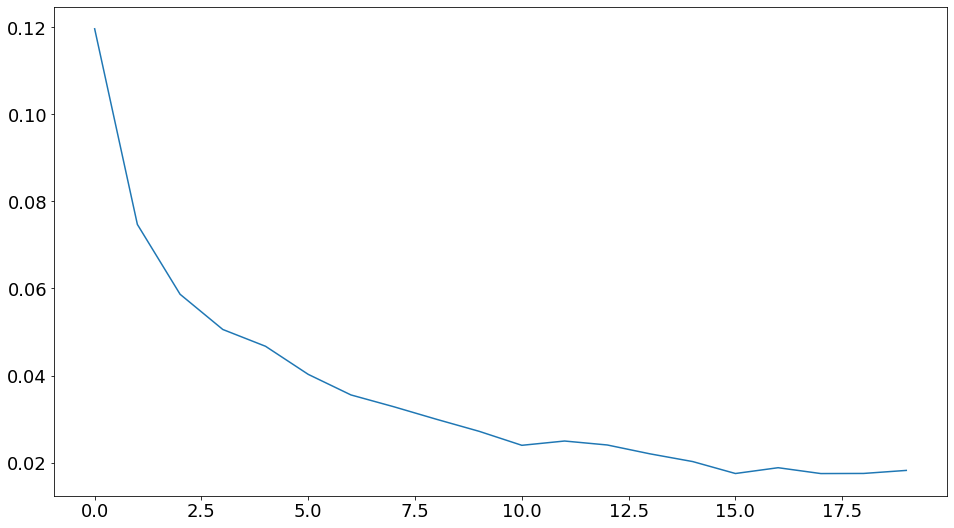

In [60]:
plt.figure(figsize = (16,9))
plt.plot(loss)
plt.show()

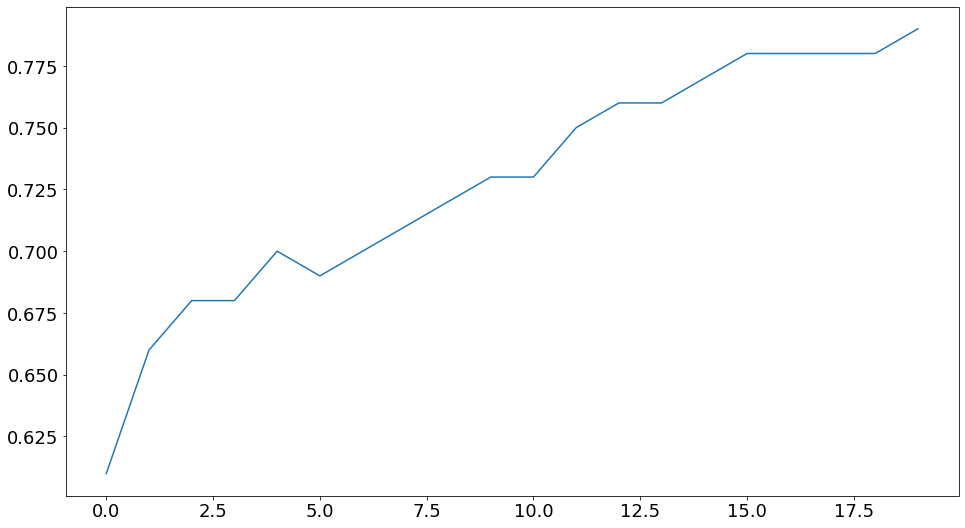

In [61]:
plt.figure(figsize = (16,9))
plt.plot(acc)
plt.show()

##Accuracy

#CALC MI

- Lưu output và lệnh tính mutual information

In [62]:
def command(exe, name, x,y, n, k, out):
    return f'{exe} {name} {x} {y} {n} {k} {out}\n'

n_samples = train

mi_x = open(os.path.join(dirX,'mi_x_layer.sh'), 'w')
mi_y = open(os.path.join(dirY,'mi_y_layer.sh'), 'w')
X_train = X_train.reshape(n_samples,-1)

y = [str(i) for i in Y_train]
x = X_train

dimX = X_train.shape[1]
dimY = 1

epochs = len(ws)
layers = len(ws[0])
samples = len(ws[0][0])

exe = './MI'
outX = [f'X_{layer:0>2}.txt' for layer in range(layers)]
outY = [f'Y_{layer:0>2}.txt' for layer in range(layers)]



for epoch in range(epochs):
    for layer in range(layers):
        dimLayer = len(ws[epoch][layer][0])
        name = f'{epoch:0>2}_{layer:0>2}.txt'

        fileX = open(os.path.join(dirX,name),'w')
        fileY = open(os.path.join(dirY,name),'w')

        for i in range(samples):
            str_info = ' '.join([f'{ws[epoch][layer][i][k]:.4f}' for k in range(len(ws[epoch][layer][i]))])
            x_infor  =  ' '.join([f'{x[i][j]:.4f}' for j in range(len(x[i]))])
            lineX = x_infor + ' '+ str_info + '\n'
            lineY = y[i] + ' ' + str_info + '\n'
            fileX.write(lineX)
            fileY.write(lineY)
        fileX.close()
        fileY.close()
        shX = command(exe, name, dimX, dimLayer, n_samples, k, outX[layer])
        shY = command(exe, name, dimY , dimLayer, n_samples, k, outY[layer])
        mi_x.write(shX)
        mi_y.write(shY)
mi_x.close()
mi_y.close()
